# Topics in Quantitative Finance - Homework 4

Assigned: August 01, 2023.
Due: **August 03, 2023 by 1PM**. 

Late homework **will not be accepted**.

$$
\newcommand{\supp}{\mathrm{supp}}
\newcommand{\E}{\mathbb{E} }
\newcommand{\Eof}[1]{\mathbb{E}\left[ #1 \right]}
\def\Cov{{ \mbox{Cov} }}
\def\Var{{ \mbox{Var} }}
\newcommand{\1}{\mathbf{1} }
\newcommand{\PP}{\mathbb{P} }
\newcommand{\Pof}[1]{\mathbb{P}\left[ #1 \right]}
%\newcommand{\Pr}{\mathrm{Pr} }
\newcommand{\QQ}{\mathbb{Q} }
\newcommand{\RR}{\mathbb{R} }
\newcommand{\DD}{\mathbb{D} }
\newcommand{\HH}{\mathbb{H} }
\newcommand{\spn}{\mathrm{span} }
\newcommand{\cov}{\mathrm{cov} }
\newcommand{\sgn}{\mathrm{sgn} }
\newcommand{\HS}{\mathcal{L}_{\mathrm{HS}} }
%\newcommand{\HS}{\mathrm{HS} }
\newcommand{\trace}{\mathrm{trace} }
\newcommand{\LL}{\mathcal{L} }
%\newcommand{\LL}{\mathrm{L} }
\newcommand{\s}{\mathcal{S} }
\newcommand{\ee}{\mathcal{E} }
\newcommand{\ff}{\mathcal{F} }
\newcommand{\hh}{\mathcal{H} }
\newcommand{\bb}{\mathcal{B} }
\newcommand{\dd}{\mathcal{D} }
\newcommand{\g}{\mathcal{G} }
\newcommand{\p}{\partial}
\newcommand{\half}{\frac{1}{2} }
\newcommand{\T}{\mathcal{T} }
\newcommand{\bi}{\begin{itemize}}
\newcommand{\ei}{\end{itemize}}
\newcommand{\beq}{\begin{equation}}
\newcommand{\eeq}{\end{equation}}
\newcommand{\beas}{\begin{eqnarray*}}
\newcommand{\eeas}{\end{eqnarray*}}
\newcommand{\cO}{\mathcal{O}}
\newcommand{\cF}{\mathcal{F}}
\newcommand{\cL}{\mathcal{L}}
\newcommand{\BS}{\text{BS}}
$$

<font color = "red">Homework is to be done by each student individually.  To receive full credit, you must email a completed copy of this Jupyter notebook to TAs 郭鵬 at [g.p@pku.edu.cn](mailto:g.p@pku.edu.cn) and 姜佳文 at [1164063524@qq.com](mailto:1164063524@qq.com) by the due date and time.  All codes must run correctly and solutions must be written up neatly in Markdown/LaTeX format. If you encounter problems with Jupyter notebook, please contact TA [郭鵬](mailto:g.p@pku.edu.cn).

## Name: <font color=blue>彭扬慧</font>

### Set up `python` environment

The following two cells load required `python` code into the notebook for the homework.

In [1]:
# import required modules
import datetime
from datetime import datetime as dt
import numpy as np
from numpy import exp, log, sqrt
import scipy.stats as ss
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from option_analytics import OptionAnalytics

## Historical volatility

In [2]:
# load daily OHLC data for Maotai(茅台) from 2019-01-02 to 2023-07-31
# courtesy to 郭大俠 
maotai = pd.read_csv('Maotai.csv')
maotai.index = maotai['Date']
maotai = maotai.drop('Date', axis=1)

In [3]:
# a quick look at the data
maotai

,Open,High,Low,Close,Volume
Date,,,,,
1/2/19,609.98,612.00,595.01,598.98,6228649
1/3/19,599.97,601.66,585.80,590.00,3097735
1/4/19,587.28,607.67,582.02,602.00,3768347
1/7/19,608.00,612.00,602.22,605.49,3475013
1/8/19,605.50,612.00,600.28,604.79,2883813
...,...,...,...,...,...
7/25/23,1800.00,1828.88,1799.99,1828.55,4308646
7/26/23,1828.55,1835.99,1815.08,1828.55,1961145
7/27/23,1836.00,1854.79,1828.70,1838.03,2034043


### 1. (15pts)

Use the `python` code provided in the lecture, especially the part on historical volatilities, to 
- a) plot daily close prices and daily log returns (using close prices) of Maotai in this period of time;
- b) calculate the followinig historical volatilities with moving window of 15 days: i) conditional standard deviation of log returns from close price, ii) Parkinson, iii) Garman-Klass, iv) Rogers-Satchell, by using the daily OHLC data stored in `Maotai.csv`. Plot all the volatilities in one figure;
- c) illustrate the leverage effect by plotting the historical volatility series from b)i) and the price series in the same figure. Remember to properly rescale the price series. 

### <font color=blue>Solution 1.</font>

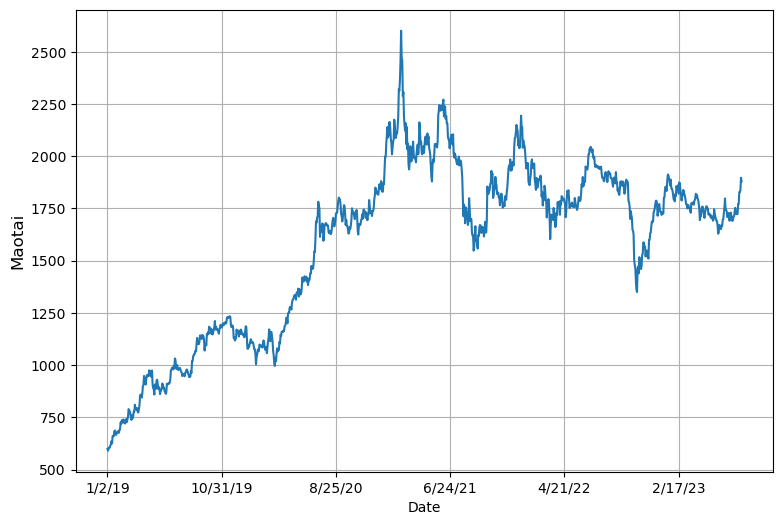

In [4]:
#(a)
# plot daily close prices
plt.figure(figsize=(9, 6))
maotai['Close'].plot()
plt.ylabel('Maotai', fontsize=12)
plt.grid();

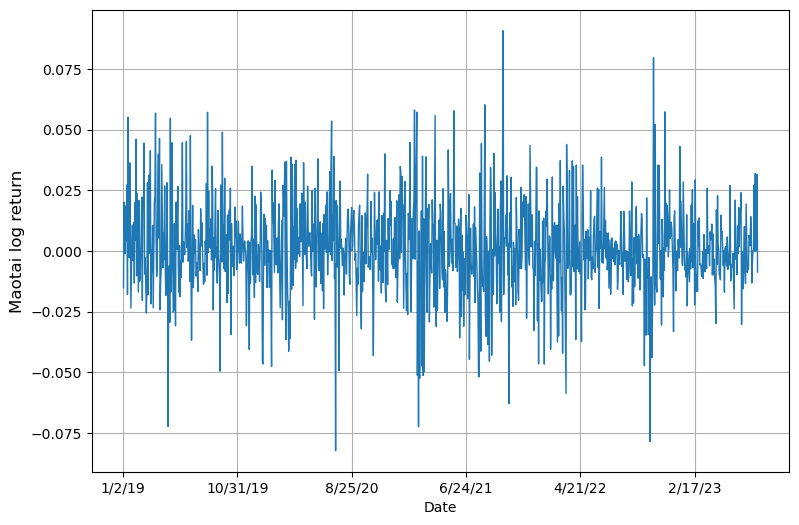

In [5]:
# log return of maotai 
r = log(maotai['Close']).diff()
# plot log return
plt.figure(figsize=(9, 6))
r.plot(lw=1)
plt.ylabel('Maotai log return', fontsize=12)
plt.grid();

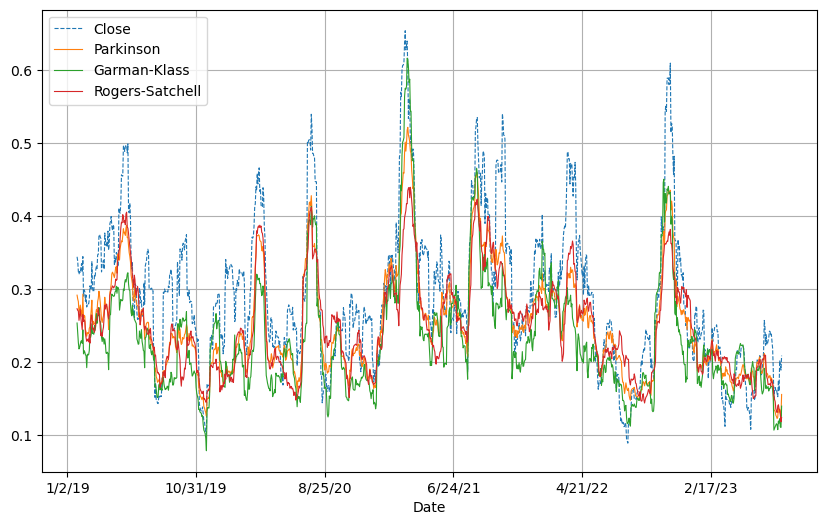

In [6]:
#(b)
class Volatilities:
    def __init__(self, OHLC, n=15, N=252):
        self.n = n
        self.N = N
        self.OHLC = pd.DataFrame(OHLC)
        self.o = self.OHLC.Open
        self.h = self.OHLC.High
        self.l = self.OHLC.Low
        self.c = self.OHLC.Close
        self.r = log(self.OHLC['Close']).diff()
        self.vols_c = [np.nan for i in range(self.n)] 
        self.vols_p = [np.nan for i in range(self.n)]
        self.vols_gk = [np.nan for i in range(self.n)] 
        self.vols_rs = [np.nan for i in range(self.n)] 
        
        for i in range(len(self.r) - self.n):
            self.vols_c += [self.r.iloc[i:(i+self.n)].std()*sqrt(self.N)]
            self.vols_p += [self.cal_vol_p(self.h.iloc[i:(i+self.n)], self.l.iloc[i:(i+self.n)])*sqrt(self.N)]
            self.vols_gk += [self.cal_vol_gk(self.o.iloc[i:(i+self.n)], self.h.iloc[i:(i+self.n)], self.l.iloc[i:(i+self.n)], self.c.iloc[i:(i+self.n)])*sqrt(self.N)]
            self.vols_rs += [self.cal_vol_rs(self.o.iloc[i:(i+self.n)], self.h.iloc[i:(i+self.n)], self.l.iloc[i:(i+self.n)], self.c.iloc[i:(i+self.n)])*sqrt(self.N)]
        self.vols = pd.DataFrame({'close': self.vols_c, 'parkinson': self.vols_p, 'garman-klass': self.vols_gk, 'rogers-satchell': self.vols_rs})
        self.vols.index = self.OHLC.index
        
    def cal_vol_p(self, H, L):
        return np.sqrt(((log(H) - log(L))**2).mean()/log(2)/4)
    
    def cal_vol_gk(self, O, H, L, C):
        term1 = ((log(O) - log(L))**2).mean()/2
        term2 = (2*log(2) - 1)*((log(C) - log(O))**2).mean()
        return np.sqrt(term1 + term2)
    
    def cal_vol_rs(self, O, H, L, C):
        u, d, c = log(H) - log(O), log(L) - log(O), log(C) - log(O)
        return np.sqrt((u*(u-c)).mean() + (d*(d-c)).mean())

maotai_vols = Volatilities(maotai)
plt.figure(figsize=(10, 6))
maotai_vols.vols['close'].plot(ls='--', label='Close', lw=0.8)
maotai_vols.vols['parkinson'].plot(lw=0.8, label='Parkinson')
maotai_vols.vols['garman-klass'].plot(lw=0.8, label='Garman-Klass')
maotai_vols.vols['rogers-satchell'].plot(lw=0.8, label='Rogers-Satchell')
plt.legend()
plt.grid();

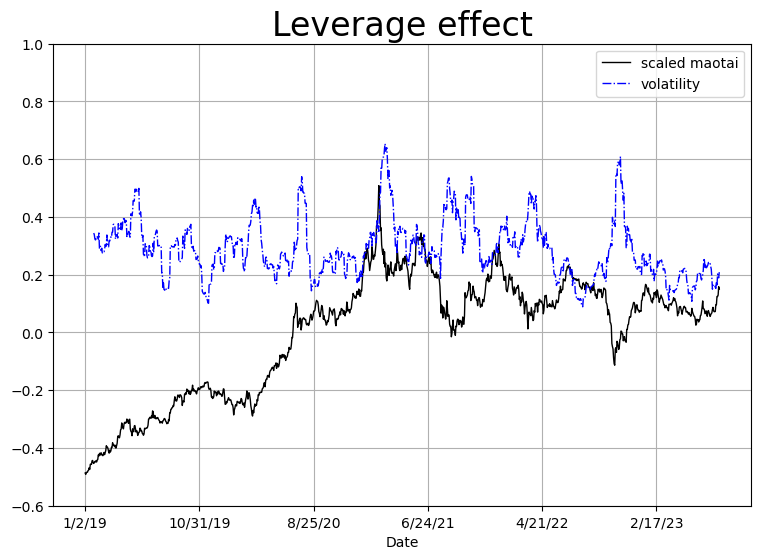

In [7]:
#(c)
def volatility(data, n=15, N=252):
    data = pd.Series(data)
    vol = [np.nan for i in range(n)]
    for i in range(len(data)-n):
        vol += [data.iloc[i:(i+n)].std()*sqrt(N)]
    return pd.DataFrame({'volatility': vol})

# leverage effect
maotai_vol = volatility(r)
maotai_vol.index = r.index
# plt.figure(figsize=(9, 6))
# plt.plot(spx_vol)
# plt.ylabel('Volatility', fontsize=12)
# plt.title('SPX historical volatility', fontsize=24)
# plt.grid();

maotai_scaled = (maotai - maotai.mean())/(maotai.max() - maotai.min())
plt.figure(figsize=(9, 6))
maotai_scaled['Close'].plot(color='k', lw=1, label='scaled maotai')
plt.ylim([-0.6, 1])
plt.plot(maotai_vol, 'b-.', lw=1, label='volatility')
plt.grid()
plt.title('Leverage effect', fontsize=24)
plt.legend();

## Implied volatility and VIX calculation

In [8]:
# load the saved data, previously downloaded from yahoo finance
aapl_calls = pd.read_csv('aapl_call_07252022.csv')
aapl_puts = pd.read_csv('aapl_put_07252022.csv')
today, expiry = '2022-07-25', '2022-08-26' 

In [9]:
# a look at the first few rows of the data
aapl_calls.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney
0,AAPL220826C00070000,2022-07-21 15:28:15,70.0,83.60,83.05,83.20,0.0,0.0,6.0,2,1.074223,True
1,AAPL220826C00105000,2022-07-20 16:14:10,105.0,48.69,48.10,48.25,0.0,0.0,10.0,6,0.588871,True
2,AAPL220826C00110000,2022-07-20 17:09:38,110.0,42.77,43.20,43.35,0.0,0.0,20.0,21,0.572270,True
3,AAPL220826C00120000,2022-07-22 19:24:02,120.0,34.81,33.40,33.55,0.0,0.0,11.0,18,0.512212,True
4,AAPL220826C00125000,2022-07-22 18:50:21,125.0,29.50,28.45,28.75,0.0,0.0,1.0,34,0.477056,True


In [10]:
# a look at the last few rows of the data
aapl_puts.tail()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney
36,AAPL220826P00170000,2022-07-22 17:45:40,170.0,16.75,17.45,17.60,0.0,0.0,3.0,16,0.274665,True
37,AAPL220826P00180000,2022-07-19 19:40:09,180.0,29.35,26.95,27.15,0.0,0.0,1000.0,150,0.293952,True
38,AAPL220826P00185000,2022-07-15 16:30:49,185.0,36.25,32.05,32.10,0.0,0.0,1.0,2,0.317390,True
39,AAPL220826P00190000,2022-07-21 18:24:42,190.0,34.75,36.90,37.10,0.0,0.0,520.0,402,0.354499,True
40,AAPL220826P00250000,2022-07-22 17:35:11,250.0,96.40,96.95,97.20,0.0,0.0,1.0,1,0.686527,True


### 2. (20pts)

Use the codes provided in lecture, especially the part on implied volatility, to 
- a) determine if there exist arbitrage opportunities in this dataset, explain your answer;
- b) calculate the implied volatilities for AAPL using option data stored in `aapl_call_07252022.csv` and `aapl_put_07252022.csv`;
- c) plot the implied volatilities versus logmoneyness; 
- d) use this dataset and the VIX formula to calculate the volatility index for AAPL.

### <font color=blue>Solution 2.</font>

In [11]:
import option_analytics

In [12]:
#(a)
aapl_opt = OptionAnalytics([aapl_calls, aapl_puts], expiry, today)

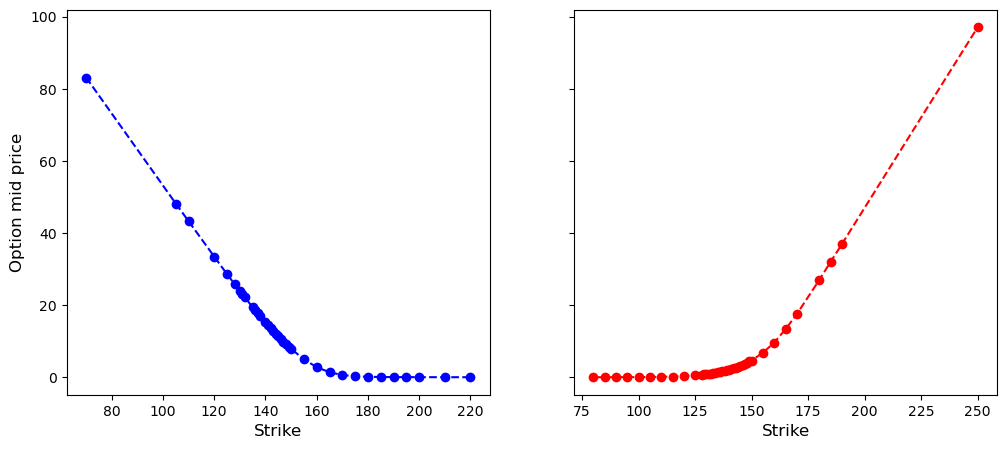

In [13]:
aapl_opt.plot_arb()

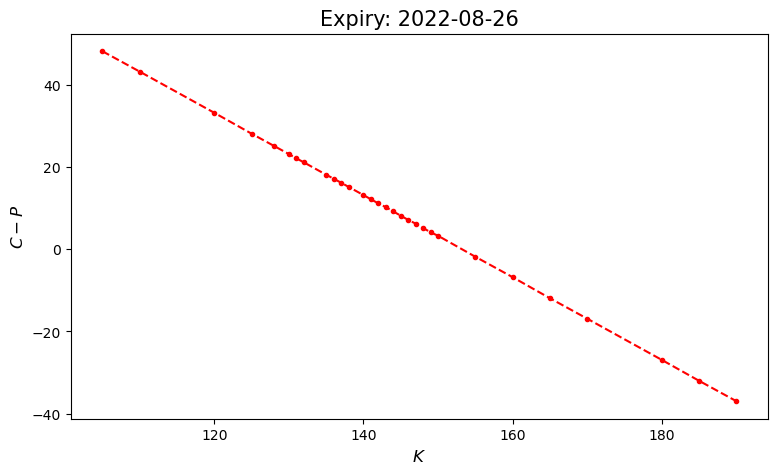

In [14]:
aapl_opt.plot_parity()

Since call option price decreases with the increase of strike and is negatively correlated,   
put option price increases with the increase of strike and is positively correlated,   
and expire is monotonic too,  
so there is no arbitrary opportunity.

In [15]:
#(b)
aapl_opt.imp_vols()

{'imp_vols': array([0.50833659, 0.5365281 , 0.48150332, 0.44203581, 0.43503084,
        0.42753686, 0.41911839, 0.41951208, 0.40484517, 0.40309294,
        0.40237123, 0.39815818, 0.38875316, 0.38352051, 0.3773059 ,
        0.38053163, 0.37379497, 0.36770762, 0.36214258, 0.36002843,
        0.35363233, 0.34899143, 0.34736538, 0.32256559, 0.30242981,
        0.28603332, 0.27588929, 0.2806888 , 0.29279635, 0.31061329]),
 'pv': 1.0005067150571048,
 's_adj': 153.19075186840305}

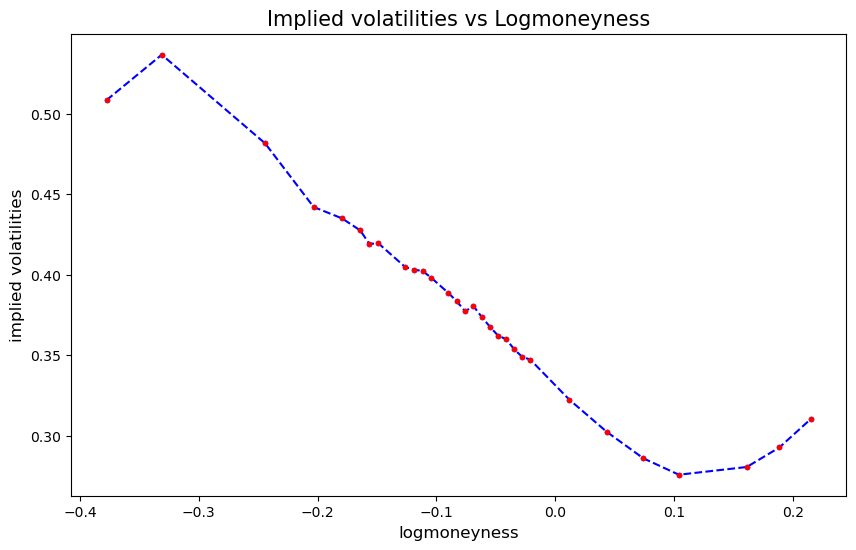

In [16]:
#(c)
aapl_opt.plot_imp_vols2()

#### (d)
the VIX formula is
$$VIX^2=\frac{2}{T}\,\sum_i\,\frac{\Delta K_i}{K_i^2}\,
Q_i(K_i)\,-\,\frac{1}{T}\,\left[\frac{F}{K_0}-1\right]^2
$$

In [17]:
#(d)
T = 1/12
for i in range(n):
    s = delta_k[i]/(k[i]^2)*Q[i]
VIX2 = 2/T *s - 1/T * ((F / K_0 - 1) ** 2)
VIX = np.sqrt(VIX2)

NameError: name 'n' is not defined